In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Gaussian_process\X_train.csv'
                          ,header=None
                          ,names=['cylinders','displacement','horsepower','weight','acceleration','year made','intercept']
                        )
X_test_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Gaussian_process\X_test.csv'
                          ,header=None
                          ,names=['cylinders','displacement','horsepower','weight','acceleration','year made','intercept'])
y_train_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Gaussian_process\y_train.csv'
                          , header=None, names=['mpg'])
y_test_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Gaussian_process\y_test.csv'
                          , header=None, names=['mpg'])

In [160]:
b_list = [5, 7, 9, 11, 13, 15]
sigma_sq_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
#b_list = [5]
#sigma_list = [.1]

In [161]:
def kernal_func(row1, row2, b=5):
    cols = len(row1)
    total = 0
    l1 = 0
    for i in range(0,cols):
        l1 += abs(row1[i] - row2[i])
    l1_sq = l1**2
    total = np.exp( (-1/b)*l1_sq)
    return total

In [162]:
%%time
ans_full_array = [] #b, sigma_sq, yi, SE
ans_array = [] #summary should have b, sigma_sq, RMSE
y_mat = y_train_raw.to_numpy()

#RMSE calc
for beta in b_list:
    
    #build Kn
    n = X_train_raw.shape[0]
    kernalij = np.array([[0.0] * n] * n)
    for i in range(0,n):
        for j in range(0,n):
            x1 = X_train_raw.iloc[i].to_numpy()
            x2 = X_train_raw.iloc[j].to_numpy()
            kernalij[i][j] = kernal_func(x1,x2, beta)

    for sigma_sq in sigma_sq_list:
        
        #predict
        SE_array = []
        for t in range(0,X_test_raw.shape[0]):
            kernalxDn = np.array([0.0] * n)
            trueval = y_test_raw.iloc[t].item()
            #build KxDn
            x0 = X_test_raw.iloc[t].to_numpy()
            for i in range(0,n):
                xn = X_train_raw.iloc[i].to_numpy()
                kernalxDn[i] = kernal_func(x0,xn)
            #predict
            kinv = np.linalg.inv(kernalij + sigma_sq*np.identity(n))
            meanval = np.dot( np.dot(kernalxDn, kinv), y_mat).item()
            SE = ((meanval - trueval)**2)
            SE_array.append(SE)
            ans_full_array.append([beta, sigma_sq, t, SE])
        
        RMSE = np.array(SE_array).mean() ** (1/2)
        ans_array.append([beta, sigma_sq, RMSE])

CPU times: total: 16min 55s
Wall time: 13min 33s


In [164]:
ans_full_array
#pd.DataFrame(ans_array, columns=['b','sigma_sq','RMSE'])
pd.DataFrame(ans_array, columns=['b','sigma_sq','RMSE']).sort_values(by=['RMSE']).to_clipboard()

## Weight only

In [121]:
X_train_weight = X_train_raw.loc[:,'weight']

In [130]:
%%time
ans_3b_predict = [] #i, x, truey, meany
y_mat = y_train_raw.to_numpy()
beta = 5
sigma_sq = 2

#build Kn
n = len(X_train_weight)
kernalij = np.array([[0.0] * n] * n)
for i in range(0,n):
    for j in range(0,n):
        x1 = [X_train_weight[i]]
        x2 = [X_train_weight[j]]
        kernalij[i][j] = kernal_func(x1,x2, beta)

#predict
for t in range(0,n):
    kernalxDn = np.array([0.0] * n)
    trueval = y_train_raw.iloc[t].item()
    #build KxDn
    x0 = [X_train_weight[t]]
    for i in range(0,n):
        xn = [X_train_weight[i]]
        kernalxDn[i] = kernal_func(x0,xn)
    #predict
    kinv = np.linalg.inv(kernalij + sigma_sq*np.identity(n))
    meanval = np.dot( np.dot(kernalxDn, kinv), y_mat).item()
    ans_3b_predict.append([t, x0[0], trueval, meanval])

CPU times: total: 1min 23s
Wall time: 42.5 s


In [131]:
ans_3b_predict[0:5]

[[0, -0.20083, -3.4458, 0.6405899246283412],
 [1, -0.038361, -5.4459, -0.6933370649759399],
 [2, -1.2251, 5.5541, 8.529680196328549],
 [3, -0.56226, 11.554, 3.667161722777422],
 [4, -1.251, 12.254, 8.680517874457136]]

In [154]:
threeb_line = pd.DataFrame(ans_3b_predict,columns=['t','x','trueval','meanval']).loc[:,['x','meanval']]
threeb_line.iloc[0:5]

,x,meanval
0,-0.200830,0.640590
1,-0.038361,-0.693337
2,-1.225100,8.529680
3,-0.562260,3.667162
4,-1.251000,8.680518


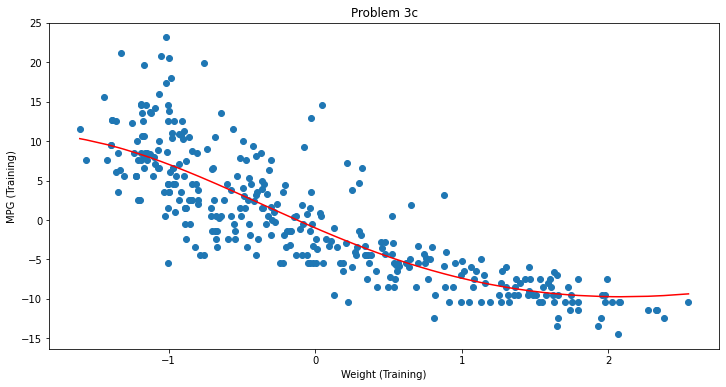

In [158]:
figure, axis = plt.subplots(1, 1, figsize=(12,6))
axis.set_xlabel("Weight (Training)")
axis.set_ylabel("MPG (Training)")
axis.set_title('Problem 3c')
plt.scatter(X_train_weight, y_train_raw)
plt.plot('x','meanval', data=threeb_line.sort_values(by=['x']), color='red');